In [ ]:
!add-apt-repository -y ppa:ubuntu-toolchain-r/test
!apt-get update
!apt-get install gcc-9 g++-9
!apt-get install gfortran-9
!apt-get install libblas-dev liblapack-dev
!apt-get install libopenblas-dev
!apt-get install scons
!apt-get install libpng-dev
!apt-get install libboost-all-dev freeglut3-dev
!apt-get install xvfb
!apt-get install libspatialindex-dev

In [ ]:
!pip install torch==1.0.1 rtree trimesh

In [ ]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 900
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-9 900

!update-alternatives --set gcc "/usr/bin/gcc-9"
!update-alternatives --set g++ "/usr/bin/g++-9"

In [ ]:
%cd /content

In [ ]:
!git clone https://github.com/mszarski/DifferentiableCloth

In [ ]:
!chmod +x DifferentiableCloth/arcsim/dependencies/taucs/configure

In [ ]:
%cd /content

In [ ]:
%cd DifferentiableCloth
%cd arcsim/dependencies/
!make -j8


In [ ]:
%cd ../..
!make -j8
%cd pysim
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes

%cd ..
%cd demo
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes

In [ ]:
##restart runtime here

In [1]:
%cd /content/DifferentiableCloth/pysim/

/content/DifferentiableCloth/pysim


In [2]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [2]:
%%writefile conf/double_hump_draping.json
{
    "frame_time": 0.08,
    "frame_steps": 2,
    "end_time": 10,
    "cloths": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_simplified_99pc.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,0.7]},
        "materials": [{"data": "materials/gray-interlock.json",
                      "stretching_mult":1e-3,
                      "bending_mult":1e4,
                       "thicken": 2}],
        "remeshing": {
            "refine_angle": 0.3,
            "refine_compression": 0.005,
            "refine_velocity": 0.5,
            "size": [10e-3, 100e-3],
            "aspect_min": 0.2
        }
    }
    ],
    "obstacles": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/double_hump_mm_simplified.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,-0.5]},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }
    ],
    "friction": 0.0,
    "obs_friction": 10000.0,
    "disable":["remeshing", "plasticity", "strainlimiting", "separation"],
    "gravity":[0, 0, -9.8],
    "magic": {"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}
}

Overwriting conf/double_hump_draping.json


In [2]:
%%writefile conf/double_hump_draping.json
{
    "frame_time": 0.08,
    "frame_steps": 2,
    "end_time": 10,
    "cloths": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_simplified_99pc.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,0.7]},
        "materials": [{"data": "materials/gray-interlock.json",
                      "stretching_mult":1e-3,
                      "bending_mult":1e4,
                       "thicken": 2}],
        "remeshing": {
            "refine_angle": 0.3,
            "refine_compression": 0.005,
            "refine_velocity": 0.5,
            "size": [10e-3, 100e-3],
            "aspect_min": 0.2
        }
    }
    ],
    "friction": 0.0,
    "obs_friction": 10000.0,
    "disable":["remeshing", "plasticity", "strainlimiting", "separation"],
    "gravity":[0, 0, -9.8],
    "magic": {"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}
}

Overwriting conf/double_hump_draping.json


In [3]:
import trimesh
import trimesh.transformations as tf
import numpy as np

curved_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm_simplified.obj',process=False)
flat_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_simplified_99pc.obj',process=False)
scene = trimesh.Scene(base_frame='world')
curved_mesh.apply_scale(0.01)
flat_mesh.apply_scale(0.01)

transform = tf.translation_matrix([-0.1,-0.3,0.7])
flat_mesh.apply_transform(transform)
f_id = scene.add_geometry(flat_mesh)

transform = tf.translation_matrix([-0.1,-0.3,-0.5])
curved_mesh.apply_transform(transform)
c_id = scene.add_geometry(curved_mesh)

handles = [24, 2, 153, 124]
steps = 20

trajectories = []

for handle in handles:
    ray_origin = flat_mesh.vertices[handle]
    
    ray_direction = curved_mesh.vertices[handle] - flat_mesh.vertices[handle]
    ray_direction = ray_direction

    locations, index_ray, index_tri = curved_mesh.ray.intersects_location(
        ray_origins=np.array([ray_origin]),
        ray_directions=np.array([ray_direction]))

    location = locations[0]
    path = np.dstack([np.linspace(ray_origin[0],location[0],steps),np.linspace(ray_origin[1],location[1],steps),np.linspace(ray_origin[2],location[2],steps)])

    path = path.squeeze()
    trajectories.append(path)

pos_trajectories = np.array(trajectories) #this is positions, not vs
v_trajectories = np.diff(pos_trajectories,axis=1) #vs
v_trajectories = v_trajectories.transpose(1,0,2)
v_trajectories = np.concatenate([v_trajectories,np.expand_dims(np.zeros_like(v_trajectories[0]),0)])

pos_trajectories = pos_trajectories.transpose(1,0,2)
pos_trajectories = np.concatenate([pos_trajectories,np.expand_dims(np.zeros_like(pos_trajectories[0]),0)])

#scene.show()

In [ ]:
#test slide
v_trajectories[22-5][:][:,0] += 100

In [4]:
!rm -rf /content/double_hump_draping_default_out

In [13]:
import networkx as nx
import torch

torch_curved_v = torch.tensor(curved_mesh.vertices,dtype=torch.float64)

#precalculate all pairs shortest paths
G = nx.Graph()
G.add_edges_from(flat_mesh.edges_unique)
P = dict(nx.all_pairs_shortest_path(G))

def contact_front_loss_graph(sim, seed_pt_idx):
    dists = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        dists.append(sim.cloths[0].mesh.nodes[i].x - torch_curved_v[i])

    z_dists = torch.stack(dists)[:,2]

    pos_z_dists = torch.nn.functional.relu(z_dists)
    thresh = 5e-3
    weights = torch.exp(-pos_z_dists/thresh)

    vertex_connectivity = torch.tensor(0.0,dtype=torch.float64)

    for j in range(len(sim.cloths[0].mesh.nodes)):
        vertex_connectivity += weights[P[seed_pt_idx][j]].prod()

    loss = -vertex_connectivity

    return loss

In [ ]:
import torch
import arcsim
import gc
import time
import json
#import sysx
import gc
import os
#import numpy as np

from datetime import datetime
now = datetime.now()
timestamp = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

out_path = '/content/double_hump_draping_default_out'

if not os.path.exists(out_path):
  os.mkdir(out_path)

with open('conf/double_hump_draping.json','r') as f:
  config = json.load(f)

def save_config(config, file):
  with open(file,'w') as f:
    json.dump(config, f)

save_config(config, out_path+'/conf.json')

torch.set_num_threads(8)
spf = config['frame_steps']
frame_time = config['frame_time']
scalev=1

##
steps = 10
trajectories = v_trajectories[:steps]
torch_pos_trajectories = torch.tensor(pos_trajectories[:steps],dtype=torch.float64)

pre_steps = 1
#epochs=10
epochs=90

boundary = [ 26,  63,  91,  62,  61, 116, 124,  93, 105,  27, 157,  78,  66,
          7, 153, 103, 129,  88, 122,  99,  89, 142, 149,  44,   6, 126,
         24,  60,  21,  11,  49, 150, 136, 139,   2,  53, 117,  36,   0]

seed_pt_idx = 83

def reset_sim(sim, epoch):
  if epoch < epochs:
    arcsim.init_physics(out_path+'/conf.json', out_path+'/out%d'%epoch,False)
  else:
    arcsim.init_physics(out_path+'/conf.json',out_path+'/out',False)

  # total_m = 0.0

  # for i in range(len(sim.cloths[0].mesh.nodes)):
  #   total_m += sim.cloths[0].mesh.nodes[i].m

  # mu = sim.obs_friction
  # mu.requires_grad = True

  # return total_m, mu

def run_sim(steps,sim,param_v):

  boundary_losses = []
  seed_pt_losses = []
  contact_losses = []
  handle_losses = []

  total_steps = (pre_steps + steps) * spf

  print("step")
  for step in range(total_steps):
    print(step)

    v_idx = step // spf - pre_steps

    if step > (pre_steps*spf)-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[v_idx,i]*scalev /spf #* spf
        #print(sim.cloths[0].mesh.nodes[handles[i]].x)
        #handle_loss += torch.norm((sim.cloths[0].mesh.nodes[handles[i]].x - torch_pos_trajectories[v_idx]))

      #print(handle_loss)
      #handle_losses.append(handle_loss)
  
      # from IPython.core.debugger import set_trace
      # set_trace()

      if step%spf == 0:
        # step_contact_loss = contact_front_loss_graph(sim, seed_pt_idx)
        # contact_losses.append(step_contact_loss)

        # step_seed_pt_loss = torch.norm((sim.cloths[0].mesh.nodes[seed_pt_idx].x - torch_curved_v[seed_pt_idx]))
        # seed_pt_losses.append(step_seed_pt_loss)

        # # loss_idxs = [*boundary]
        # loss_idxs = [*handles]
        # step_boundary_loss = torch.tensor(0.0,dtype=torch.float64)
        # for i in loss_idxs:
        #   step_boundary_loss += torch.norm(torch_curved_v[i] - sim.cloths[0].mesh.nodes[i].x, p=1)

        # boundary_losses.append(step_boundary_loss)

        handle_loss = torch.tensor(0.0,dtype=torch.float64)

        for i in range(len(handles)):
          handle_loss += torch.norm((sim.cloths[0].mesh.nodes[handles[i]].x - torch_pos_trajectories[v_idx,i]))

        handle_losses.append(handle_loss)

        #print(f"contact loss: {step_contact_loss}, seed_pt_loss: {step_seed_pt_loss}, boundary loss: {step_boundary_loss}")

    arcsim.sim_step()

  # v_limit = 0.5 #was 0.25
  # stiffness = 2
  # weight = 2/30 * steps * 1/7 * len(loss_idxs)
  # v_constraint = torch.sum(weight / (1.0+torch.exp(stiffness*(1.0 - (torch.abs(param_v)/v_limit)))))

  # avg = torch.mean(param_v,dim=1,keepdim=True)
  # reg = (torch.norm(param_v-avg, dim=2)**2).mean()

  #total_loss = loss #+ reg #+ v_constraint

  # # e = [0,20*spf,40*spf]
  # e = [0,20,40]
  # sw = [1.0,0.0,0.0]
  # cw = [0.0,1.0,0.0]
  # bw = [0.0,0.0,1.0]
  # seed_pt_weight = torch.tensor(np.interp(list(range(steps*spf)),e,sw))
  # contact_weight = torch.tensor(np.interp(list(range(steps*spf)),e,cw))
  # boundary_weight = torch.tensor(np.interp(list(range(steps*spf)),e,bw))

  # seed_pt_weight = torch.tensor(np.interp(list(range(steps)),e,sw))
  # contact_weight = torch.tensor(np.interp(list(range(steps)),e,cw))
  # boundary_weight = torch.tensor(np.interp(list(range(steps)),e,bw))

  # contact_loss_steps = torch.stack(contact_losses,dim=0)
  # contact_loss = torch.sum(contact_loss_steps*contact_weight)

  # seed_pt_loss_steps = torch.stack(seed_pt_losses,dim=0)
  # seed_pt_loss = torch.sum(seed_pt_loss_steps*seed_pt_weight)

  # boundary_loss_steps = torch.stack(boundary_losses,dim=0)
  # boundary_loss = torch.sum(boundary_loss_steps*boundary_weight)

  # avg = torch.mean(contact_loss_steps)
  # var = torch.norm(contact_loss_steps-avg)**2
  # reg = var/steps

  #reg_lambda = 0
  # seed_pt_lambda = 1
  # contact_lambda = 1e-2
  # boundary_lambda = 1e-1
  # print(f"contact loss: {contact_loss*contact_lambda}, seed_pt_loss: {seed_pt_loss*seed_pt_lambda}, boundary loss: {boundary_loss*boundary_lambda}")

  # total_loss = contact_loss*contact_lambda + seed_pt_loss*seed_pt_lambda + boundary_loss*boundary_lambda

  # total_loss = seed_pt_loss*seed_pt_lambda

  handle_loss_steps = torch.stack(handle_losses,dim=0)
  handle_loss = torch.sum(handle_loss_steps)

  for tensor in handle_loss_steps:
      del tensor
  del handle_loss_steps

  del handle_losses

  total_loss = handle_loss

  return total_loss


with open(out_path+('/log%s.txt'%timestamp),'w',buffering=1) as f:
  tot_step = 1
  sim=arcsim.get_sim()
  #total_m, _ = reset_sim(sim,0)
  #print(total_m)

  #total_m = 1.2

  param_v = torch.zeros([steps, 4,3],dtype=torch.float64, requires_grad=True)
  #m_trajectories = np.array(trajectories)
  #m_trajectories[:,:,2] += 5.0*(total_m /4 * -(-9.8))

  #param_v = torch.tensor(m_trajectories/(frame_time/spf),dtype=torch.float64, requires_grad=True)

  # optimizer = torch.optim.Adam([param_v],lr=0.01)
  # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=0, verbose=True)

  optimizer = torch.optim.Adam([param_v],lr=5.0)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1, verbose=True)

  epoch = 0
  while True:
    reset_sim(sim, epoch)
    st = time.time()

    optimizer.zero_grad()

    loss = run_sim(steps, sim, param_v)
    en0 = time.time()

    loss.backward(retain_graph=True)

    en1 = time.time()
    print("=======================================")
    #print(param_v.data)
    #print(param_v.grad.data)
    f.write('epoch {}:  loss={} \n'.format(epoch,  loss.data))
    print('epoch {}:  loss={} \n'.format(epoch, loss.data))

    print('forward time={}'.format(en0-st))
    print('backward time={}'.format(en1-en0))

    #param_v.grad.data[:,:,2] = torch.zeros(steps,len(handles))
    #param_v.grad.data.clamp_(-25,25)

    optimizer.step()

    arcsim.delete_mesh(sim.cloths[0].mesh)
    scheduler.step(loss.item())

    del loss

    if epoch>=epochs:
      break
    epoch = epoch + 1


print("done")


step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
epoch 0:  loss=15.017693390738128 

forward time=7.801627159118652
backward time=18.716453552246094
step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
epoch 1:  loss=19.961012094342376 

forward time=8.967188596725464
backward time=18.29836678504944


In [12]:
param_v

tensor([[[  0.8377,   2.5314,   2.1133],
         [ 11.8899,  34.8656,   3.9857],
         [ -0.4684,   6.1564,   1.7516],
         [  9.6893, -18.3028,   3.8118]],

        [[ -4.8033,  10.5199,   2.2902],
         [ 19.3874,  44.8885,  26.0640],
         [  4.3959, -12.5100,   6.9147],
         [ 23.9655, -24.4589,  14.3070]],

        [[-17.3837,  21.3474,  12.5586],
         [ 30.1383,  60.6152,  34.3169],
         [-21.8006, -24.3611,  14.1370],
         [ 42.6947, -60.6040,  30.9001]],

        [[-25.0070,  26.6591,  17.3345],
         [ 55.1850,  68.3427,  57.7911],
         [-24.3981, -31.3476,  21.0423],
         [ 54.8837, -59.9897,  69.6097]],

        [[-27.3870,  32.8403,  19.0082],
         [ 59.8900,  73.4817,  73.7267],
         [-28.5890, -32.2960,  24.3576],
         [ 51.8597, -71.6679,  44.7967]],

        [[-24.8659,  39.0328,  26.5672],
         [ 59.5492,  61.6210,  72.0866],
         [-21.9766, -31.1867,  25.7669],
         [ 56.4970, -55.2531,  52.5469]],

    

In [6]:
%cd /content/DifferentiableCloth/pysim

/content/DifferentiableCloth/pysim


In [7]:
%%writefile visualize.py
import torch
import arcsim

with torch.autograd.profiler.profile() as prof:
	  arcsim.msim(4,['arcsim','replay','/content/double_hump_draping_default_out/out', '45.0'])
print(prof)

Overwriting visualize.py


In [8]:
!xvfb-run -s "-screen 0 2560x1440x24 -ac +extension GLX +render -noreset" python visualize.py

main
4
arcsim replay /content/double_hump_draping_default_out/out
reply 1 
reply 2 
reply 3 
reply 4 
reply 5 
reply 6 
/content/double_hump_draping_default_out/out/0000
reply 7 
45.0
45
/content/double_hump_draping_default_out/out/0000.png
/content/double_hump_draping_default_out/out/0001
/content/double_hump_draping_default_out/out/0001.png
/content/double_hump_draping_default_out/out/0002
/content/double_hump_draping_default_out/out/0002.png
/content/double_hump_draping_default_out/out/0003
/content/double_hump_draping_default_out/out/0003.png
/content/double_hump_draping_default_out/out/0004
/content/double_hump_draping_default_out/out/0004.png
/content/double_hump_draping_default_out/out/0005
/content/double_hump_draping_default_out/out/0005.png
/content/double_hump_draping_default_out/out/0006
/content/double_hump_draping_default_out/out/0006.png
/content/double_hump_draping_default_out/out/0007
/content/double_hump_draping_default_out/out/0007.png
/content/double_hump_draping_de

In [9]:
import pathlib
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

frames = []
for png_file in sorted(list(pathlib.Path('/content/double_hump_draping_default_out/out').glob('*.png'))):
    frames.append(plt.imread(png_file))
    #print(bmp_file)
    

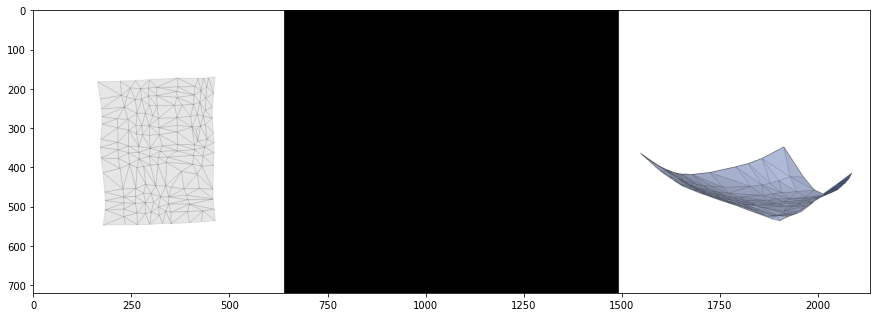

In [10]:
from matplotlib import animation, rc
from IPython.display import HTML

plt.rcParams["figure.figsize"] = (15,15)

fig = plt.figure()

ims = []
for i in range(len(frames)):
    im = plt.imshow(frames[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

rc('animation', html='jshtml')
ani

In [ ]:
HTML(ani.to_html5_video())

In [ ]:
ani.save('diffdrape.mp4')

In [ ]:
torch.save(param_v, 'trajectory.pt')

In [ ]:
import trimesh
import trimesh.transformations as tf
import numpy as np

curved_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm_simplified.obj',process=False)
flat_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_simplified_99pc.obj',process=False)
scene = trimesh.Scene(base_frame='world')
curved_mesh.apply_scale(0.01)
flat_mesh.apply_scale(0.01)

transform = tf.translation_matrix([-0.1,-0.3,0.7])
flat_mesh.apply_transform(transform)
f_id = scene.add_geometry(flat_mesh)

transform = tf.translation_matrix([-0.1,-0.3,-0.5])
curved_mesh.apply_transform(transform)
c_id = scene.add_geometry(curved_mesh)

handles = [24, 2, 153, 124]
steps = 20

for i in range(len(handles)):

    original_path = trimesh.load_path(np.cumsum(trajectories[:,i,:],axis=0) + + flat_mesh.vertices[handles[i]])
    optimized_path = trimesh.load_path(np.cumsum(param_v.detach().numpy()[:,i,:]*0.125,axis=0) + flat_mesh.vertices[handles[i]])
    scene.add_geometry(original_path)
    scene.add_geometry(optimized_path)

scene.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection = '3d')

for i in range(len(handles)):
    trajectory = (np.cumsum(param_v.detach().numpy()[:,i,:]*0.04,axis=0) + flat_mesh.vertices[handles[i]]).T
    grad = (param_v.detach().numpy()[:,i,:]).T
    ax.plot(trajectory[0], trajectory[1], trajectory[2], marker = 'x')
    ax.quiver(trajectory[0], trajectory[1], trajectory[2], grad[0], grad[1], grad[2], length=0.5, normalize=True) #set z component to 0 to better visualize other gradients. this seems useful

plt.show()

In [20]:
!pip install guppy3

     |████████████████████████████████| 614kB 5.6MB/s 


In [21]:
from guppy import hpy
h = hpy()
h.heap()

/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:86: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Partition of a set of 752484 objects. Total size = 229455265 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0    710   0 132972307  58 132972307  58 numpy.ndarray
     1 210935  28 30426964  13 163399271  71 str
     2 191910  26 14831608   6 178230879  78 tuple
     3  80550  11  6497396   3 184728275  81 bytes
     4  40987   5  5936680   3 190664955  83 types.CodeType
     5  13747   2  5767440   3 196432395  86 dict (no owner)
     6  38950   5  5297200   2 201729595  88 function
     7  35901   5  4550616   2 206280211  90 list
     8   4181   1  4058984   2 210339195  92 type
     9   2039   0  2913448   1 213252643  93 dict of module
<1580 more rows. Type e.g. '_.more' to view.>